In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
import seaborn as sns 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import os
os.getcwd()

'/home/dhruv/Documents/Dhruv_CV/VARIATIONAL-AUTOENCODER-WITH-ARBITRARY-CONDITIONING-VAEAC-/code'

In [3]:
os.chdir("../")
os.getcwd()

'/home/dhruv/Documents/Dhruv_CV/VARIATIONAL-AUTOENCODER-WITH-ARBITRARY-CONDITIONING-VAEAC-'

In [17]:
data_dir = "Data/split_data"
os.makedirs(data_dir, exist_ok=True)

checkpoint_dir = "vaeac_checkpoints_vertical"
os.makedirs(checkpoint_dir, exist_ok=True)

In [18]:
class MaskedMNISTDataset(Dataset):
    def __init__(self, root_dir, mask_type="horizontal", mode= "train", transform=None):
        """
        root_dir: path to 'split_data/train' or 'split_data/test'
        mask_type: 'horizontal' or 'vertical'
        """
        assert mask_type in ["horizontal", "vertical"], "mask_type must be 'horizontal' or 'vertical'"
        
        self.root_dir = root_dir
        self.mask_type = mask_type
        self.transform = transform
        self.mode = mode
        # Folder mapping based on mask type
        self.folders = {
            "original": "original",
            "mask": f"{mask_type}_mask",
            "observed": f"{mask_type}_mask_observed_image",
            "unobserved": f"{mask_type}_mask_unobserved_image"
        }

        # Get sorted filenames (consistent across folders)
        self.file_names = sorted(os.listdir(os.path.join(os.getcwd(), self.root_dir, self.mode, self.folders["original"])))

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        fname = self.file_names[idx]

        # Load all images as grayscale
        images = {}
        for key, folder in self.folders.items():
            img_path = os.path.join(os.getcwd(), self.root_dir, self.mode, folder, fname)
            img = Image.open(img_path).convert("L")
            
            if self.transform:
                img = self.transform(img)
            images[key] = img

        return images

In [19]:
root_dir = "Data/split_data"

mask_type = "vertical"

mode = "train"

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = MaskedMNISTDataset(root_dir=root_dir, mask_type=mask_type, mode= mode, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [20]:
dataset[0].keys()

dict_keys(['original', 'mask', 'observed', 'unobserved'])

/home/dhruv/Documents/Dhruv_CV/VARIATIONAL-AUTOENCODER-WITH-ARBITRARY-CONDITIONING-VAEAC-/.venv/lib/python3.12/site-packages/torch/_tensor.py:1024: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


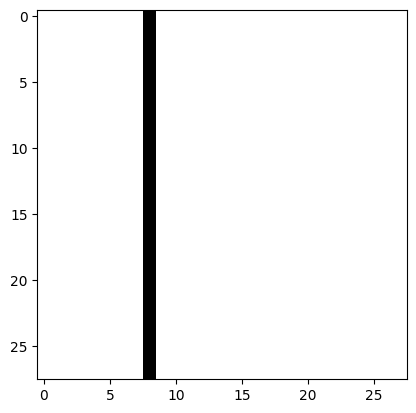

In [21]:
plt.imshow(dataset[0]["mask"].resize(28,28), cmap="gray")
plt.show()

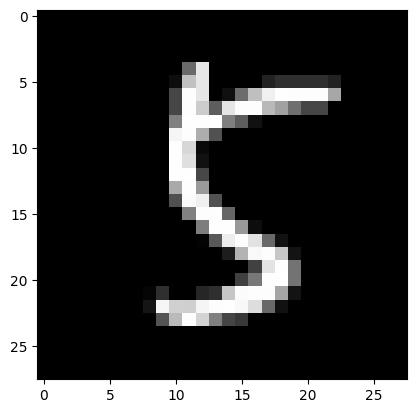

In [22]:
plt.imshow(dataset[0]["original"].resize(28,28), cmap="gray")
plt.show()

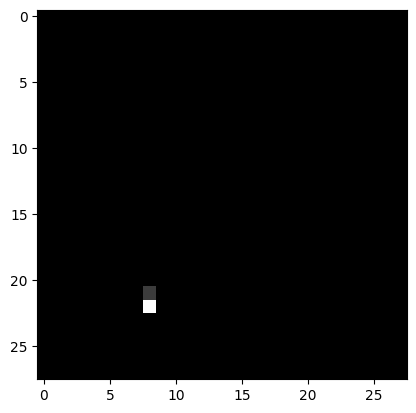

In [23]:
plt.imshow(dataset[0]["unobserved"].resize(28,28), cmap="gray")
plt.show()

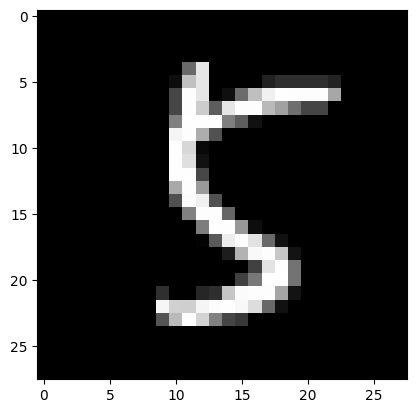

In [24]:
plt.imshow(dataset[0]["observed"].resize(28,28), cmap="gray")
plt.show()

In [27]:
# Encoder / Proposal Network
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 14x14 -> 7x7
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)
    
    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

# Prior Network
class Prior(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 32, 4, 2, 1),  # 1 channel image + 1 channel mask = 2 channels
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)

    def forward(self, x_b, b):
        xb = torch.cat([x_b, b], dim=1)
        h = self.conv(xb)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim + 2*28*28, 64*7*7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, z, x_b, b):
        xb_flat = torch.cat([x_b.view(x_b.size(0), -1), b.view(b.size(0), -1)], dim=1)
        h = torch.cat([z, xb_flat], dim=1)
        h = self.fc(h)
        h = h.view(h.size(0), 64, 7, 7)
        x_recon = self.deconv(h)
        return x_recon

# VAEAC model
class VAEAC(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.prior = Prior(latent_dim)
        self.decoder = Decoder(latent_dim)
    
    def forward(self, x, x_b, b):
        mu_q, logvar_q = self.encoder(x)
        std = torch.exp(0.5 * logvar_q)
        eps = torch.randn_like(std)
        z = mu_q + eps * std

        mu_p, logvar_p = self.prior(x_b, b)
        x_recon = self.decoder(z, x_b, b)
        return x_recon, mu_p, logvar_p, mu_q, logvar_q


In [13]:
latent_dim = 20

batch_size = 64

epochs = 50

learning_rate = 1e-3

root_dir = "Data/split_data"

mask_type = "vertical"

mode = "train"

transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset = MaskedMNISTDataset(root_dir=root_dir, mask_type=mask_type, mode= mode, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


vaeac = VAEAC(latent_dim).to(device)
optimizer = optim.Adam(vaeac.parameters(), lr=learning_rate)

def vaeac_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

for epoch in range(epochs):
    vaeac.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        original_image = data["original"]
        mask_image = data["mask"]
        observed_image = data["observed"]
        unobserved_image = data["unobserved"]
        
        original_image, mask_image, observed_image, unobserved_image = original_image.to(device), mask_image.to(device), observed_image.to(device), unobserved_image.to(device)
        
        optimizer.zero_grad()
        
        recon, mu_p, logvar_p, mu_q, logvar_q = vaeac(original_image, observed_image, mask_image)
        loss = vaeac_loss(recon, unobserved_image, mu_q, logvar_q)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}")
    
    if (epoch+1)%10 == 0:
        torch.save(vaeac.state_dict(), os.path.join(checkpoint_dir, f"vaeac_dict_epoch_{epoch+1}.pth"))
        torch.save(vaeac, os.path.join(checkpoint_dir, f"vaeac_epoch_{epoch+1}.pth"))

torch.save(vaeac.state_dict(), os.path.join(checkpoint_dir, f"final_vaeac_dict_epoch_{epoch+1}.pth"))
torch.save(vaeac, os.path.join(checkpoint_dir, f"final_vaeac_epoch_{epoch+1}.pth"))

Epoch 1/50, Loss: 14.1585
Epoch 2/50, Loss: 6.1378
Epoch 3/50, Loss: 5.4808
Epoch 4/50, Loss: 5.1564
Epoch 5/50, Loss: 4.9823
Epoch 6/50, Loss: 4.8286
Epoch 7/50, Loss: 4.7456
Epoch 8/50, Loss: 4.6458
Epoch 9/50, Loss: 4.5881
Epoch 10/50, Loss: 4.5466
Epoch 11/50, Loss: 4.5076
Epoch 12/50, Loss: 4.4625
Epoch 13/50, Loss: 4.4214
Epoch 14/50, Loss: 4.3926
Epoch 15/50, Loss: 4.3495
Epoch 37/50, Loss: 4.0478
Epoch 38/50, Loss: 4.0503
Epoch 39/50, Loss: 4.0296
Epoch 40/50, Loss: 4.0389
Epoch 41/50, Loss: 4.0178
Epoch 42/50, Loss: 4.0145
Epoch 43/50, Loss: 4.0302
Epoch 44/50, Loss: 3.9888
Epoch 45/50, Loss: 3.9975
Epoch 46/50, Loss: 3.9782
Epoch 47/50, Loss: 3.9723
Epoch 48/50, Loss: 3.9770
Epoch 49/50, Loss: 3.9608
Epoch 50/50, Loss: 3.9660


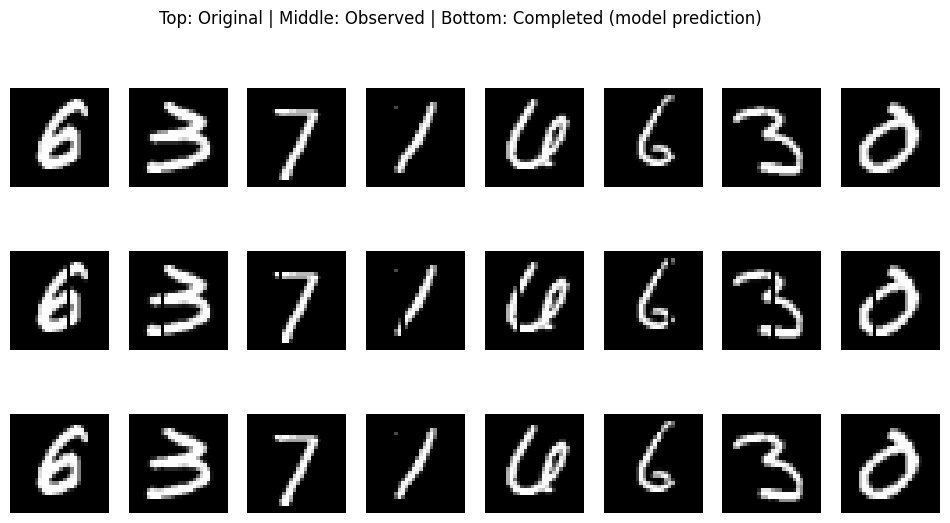

In [14]:
# Test dataset

root_dir = "Data/split_data"

mask_type = "vertical"

mode = "test"

transform = transforms.Compose([
    transforms.ToTensor(),
])


test_dataset = MaskedMNISTDataset(root_dir=root_dir, mask_type=mask_type, mode= mode, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

vaeac.eval()
mu_all = []
proposal_mu_all = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
        
        original_image = data["original"]
        mask_image = data["mask"]
        observed_image = data["observed"]
        unobserved_image = data["unobserved"]
        
        original_image, mask_image, observed_image, unobserved_image = original_image.to(device), mask_image.to(device), observed_image.to(device), unobserved_image.to(device)
        
        recon, mu_p, logvar_p, mu_q, logvar_q = vaeac(original_image, observed_image, mask_image)
        mu_all.append(mu_p)
        proposal_mu_all.append(mu_q)
        
        # Show first batch of reconstructions
        
        if batch_idx == 0:
            n = 8

            # Combine predicted + observed for final completion
            completed_images = observed_image + (1 - mask_image) * recon

            # Arrange images for visualization
            comparison = torch.cat([
                original_image[:n],           # Ground truth
                observed_image[:n],           # Masked input
                completed_images[:n],         # Reconstructed/final
            ])

            comparison = comparison.cpu()

            plt.figure(figsize=(12, 6))
            for i in range(n * 3):
                plt.subplot(3, n, i + 1)
                plt.imshow(comparison[i][0], cmap='gray')
                plt.axis('off')

            plt.suptitle("Top: Original | Middle: Observed | Bottom: Completed (model prediction)")
            plt.show()
            break


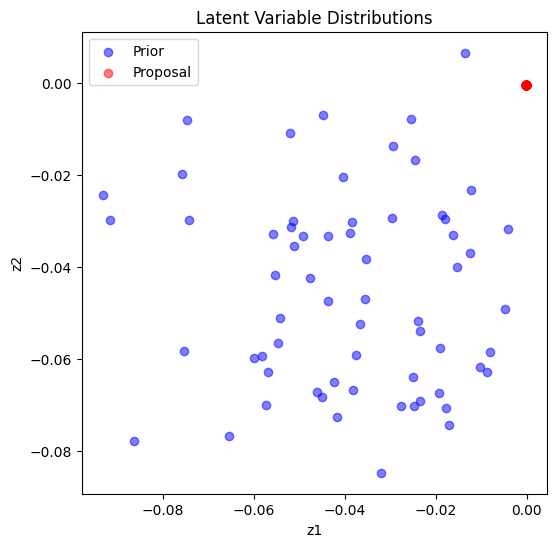

In [15]:
# Plot latent space distributions
mu_all = torch.cat(mu_all, dim=0)
proposal_mu_all = torch.cat(proposal_mu_all, dim=0)

plt.figure(figsize=(6,6))
plt.scatter(mu_all[:,0].cpu(), mu_all[:,1].cpu(), c='blue', alpha=0.5, label='Prior')
plt.scatter(proposal_mu_all[:,0].cpu(), proposal_mu_all[:,1].cpu(), c='red', alpha=0.5, label='Proposal')
plt.title('Latent Variable Distributions')
plt.xlabel('z1')
plt.ylabel('z2')
plt.legend()
plt.savefig("VAEAC_vertical_mask_latent.png")
plt.show()